# Capstone Project 1: Instacart Market Basket Analysis

## History of 5 orders predict the Diet more accurately than just using 1 order of a customer

Previously, I developed an algorithm that predicts the eating behavior of Instacarcart customers (Meat Lovers, Pescatarian, Vegan and NonVegan).  Initially, I used the provided training set which contain only 1 order history of a customer.  However, using only 1 order History per customer does not predict the eating behavior of customers accurately shown in https://github.com/DrAugustine1981/InstacartCapstoneProject/blob/master/EDA.ipynb (In 107).  

In this IPython Notebook.  I used the same algorithm but this time using atleast 5 order history for each user which improved accuracy of the model.  This algorithm is tested in 3 different datasets with different 10,000 customers.

In [115]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
% matplotlib inline
import seaborn as sns
from matplotlib import rcParams
sns.set_style("whitegrid")
sns.set_context("poster")

In [2]:
## Read and Save all Tables in a DF
prod=pd.read_csv('products.csv')
aisles=pd.read_csv('aisles.csv')
dep=pd.read_csv('departments.csv')
orders=pd.read_csv('orders.csv')
train=pd.read_csv('order_products__train.csv')
prior=pd.read_csv('order_products__prior.csv')
samp=pd.read_csv('sample_submission.csv')

In [3]:
aisles.head()

,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation


In [4]:
## Orders Table Separated to three
oprior=orders[orders.eval_set=='prior']
otrain=orders[orders.eval_set=='train']
otest=orders[orders.eval_set=='test']

In [5]:
oprior.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


In [6]:
oprior.user_id.unique().size

206209

In [7]:
##Order frequency per order
orfreq=oprior.groupby('user_id')['order_number'].agg(['max'])
orfreq.columns=['max_order_num']



In [8]:
orfreq.head()
orfreq['user_id']=orfreq.index.get_level_values('user_id').values
orfreq.head()

,max_order_num,user_id
user_id,,
1,10,1
2,14,2
3,12,3
4,5,4
5,4,5


In [9]:
## Most number pf orders
orfreq['max_order_num'].max()

99

In [10]:
##Customer with most number of orders
orfreq['max_order_num'].idxmax()

210

In [11]:
#Average maximum order
orfreq['max_order_num'].mean()

15.590367054784224

In [12]:
## Filter data with atleast 5 orders to gain order history
sam=orfreq[orfreq['max_order_num']>=5]

In [13]:
## Get random 10,000 samples from 206,209 users
sample1=sam.sample(n=10000, replace=False, random_state=0, axis=0)

In [125]:
def Diet_Class(sample1): 
## Merge sample1 DF with oprior, prior, prod, dep and aisle for a more complete Data Frame
    sample=sample1.merge(oprior)
    sample=sample.merge(prior)
    sample=sample.merge(prod)
    sample=sample.merge(dep)
    sample=sample.merge(aisles)
    
    ### Count total product per order per user
    user=sample.groupby('user_id')['order_id'].value_counts()
    user=pd.DataFrame(user)
    user.columns=['prod_tot']
    user['user_id']=user.index.get_level_values('user_id').values
    user['order_id']=user.index.get_level_values('order_id').values
    
    ## Count orders from ever aisle per order
    aisle=sample.groupby('order_id')['aisle_id'].value_counts()
    aisle=pd.DataFrame(aisle)
    aisle.columns=['ais_count']
    aisle['aisle_id']=aisle.index.get_level_values('aisle_id').values
    aisle['order_id']=aisle.index.get_level_values('order_id').values
        
    C=user.merge(aisle)
    C=C.loc[:,['user_id', 'order_id', 'aisle_id', 'ais_count', 'prod_tot']]
    
    ##Probablity distribution of aisle per order
    C['ais_prob_per_or']=C['ais_count']/C['prod_tot']
    C=C.merge(aisles)
    C.sort_values(by=['user_id', 'order_id'])
    
    
    ##aisle count per user
    A=C.groupby('user_id')['aisle_id'].value_counts()
    A=pd.DataFrame(A)
    A.columns=['ais_count']
    A['user_id']=A.index.get_level_values('user_id').values
    A['aisle_id']=A.index.get_level_values('aisle_id').values

    ## ais/order  total aisle products / total order per user
    A=A.merge(orfreq)
    A.head()
    A=A.loc[:, ['user_id', 'aisle_id', 'ais_count', 'max_order_num']]
    A['ais/order']=A.ais_count/A.max_order_num
    
    ## Total products ordered from Meat & Seafood Aisles
    MS=A[(A.aisle_id==5)|(A.aisle_id==7)|(A.aisle_id==15)|(A.aisle_id==34)|(A.aisle_id==35)|(A.aisle_id==39)|(A.aisle_id==49)|(A.aisle_id==95)|(A.aisle_id==96)|(A.aisle_id==106)|(A.aisle_id==122)]
    
    ##Eats Meat and Fish
    M=MS[(MS.aisle_id==5)|(A.aisle_id==7)|(A.aisle_id==35)|(A.aisle_id==49)|(A.aisle_id==96)|(A.aisle_id==106)|(A.aisle_id==122)]
    MF=M.user_id.unique()
    Meat_L=pd.DataFrame(MF, columns=['user_id'])
    Meat_L['Diet']='Meat_Lovers'
    
    ##Pescatarian that eat and not eat other meat
    P=MS[(MS.aisle_id==15)|(MS.aisle_id==34)|(MS.aisle_id==39)|(MS.aisle_id==95)]
    F=P.user_id.unique()
    
    ## Pescatarian customers
    Pesca=np.setdiff1d(F,MF)
    Pesca=pd.DataFrame(Pesca, columns=['user_id'])
    Pesca['Diet']='Pescatarian'

    ## All Vegetarians
    Veg=A.loc[~A.user_id.isin(MS.user_id)]

    # NonVegan 
    NV=Veg[(Veg.aisle_id==86)|(Veg.aisle_id==2)|(Veg.aisle_id==21)|(Veg.aisle_id==53)|(Veg.aisle_id==84)|(Veg.aisle_id==108)|(Veg.aisle_id==120)]
    F1=NV.user_id.unique()

    NonVeg=pd.DataFrame(F1, columns=['user_id'])
    NonVeg['Diet']='NonVegan'
    
    ##Vegans
    Vegans=Veg.loc[~Veg.user_id.isin(F1)]
    Vega=Vegans.user_id.unique()
    Vega=pd.DataFrame(Vega, columns=['user_id'])
    Vega['Diet']='Vegan'
    
    ## Merge all DataFrame of Different Diets
    Sample_class=pd.concat([Meat_L, Pesca, NonVeg, Vega])
    
    ## Merge Sample_class with DataFrame of all ordered products
    B=sample.loc[:, ['user_id', 'aisle_id', 'product_name']]
    B=B.merge(Sample_class)
    
    #Separate B data_Frame according to Diet
    D1=B[B.Diet=='Meat_Lovers']
    D2=B[B.Diet=='Pescatarian']
    D3=B[B.Diet=='NonVegan']
    D4=B[B.Diet=='Vegan']
    
    ## Probability of buying product given their Diet
   
    #P(product|Meat_Lovers)
    Prob1=D1.product_name.value_counts()/D1.product_name.size
    Prob1=pd.DataFrame(Prob1).reset_index()
    Prob1.columns=['product_name', 'Prob(prod|Meat)']
    
    #P(product|Pescatarian)
    Prob2=D2.product_name.value_counts()/D2.product_name.size
    Prob2=pd.DataFrame(Prob2).reset_index()
    Prob2.columns=['product_name', 'Prob(prod|Pesc)']

    # P(product|NonVegan)
    Prob3=D3.product_name.value_counts()/D3.product_name.size
    Prob3=pd.DataFrame(Prob3).reset_index()
    Prob3.columns=['product_name', 'Prob(prod|NonVeg)']
     
    #P(product|Vegan)
    Prob4=D4.product_name.value_counts()/D4.product_name.size
    Prob4=pd.DataFrame(Prob4).reset_index()
    Prob4.columns=['product_name', 'Prob(prod|Vegan)']
    
    Prob=Prob1.merge(Prob2)
    Prob=Prob.merge(Prob3)
    Prob=Prob.merge(Prob4)
    Prob=Prob.merge(prod)
    
    Pie=Sample_class.Diet.value_counts().sort_index().plot(kind='pie', autopct='%1.0f%%')
    Aisle_Prob=Prob.groupby('aisle_id')['Prob(prod|Meat)','Prob(prod|Pesc)', 'Prob(prod|NonVeg)', 'Prob(prod|Vegan)'].sum()
    
    
  
    return Pie, Aisle_Prob.plot(), Aisle_Prob
    
   


C:\Users\pamel\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:49: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


(<matplotlib.axes._subplots.AxesSubplot at 0x1bee4bd4400>,
           Prob(prod|Meat)  Prob(prod|Pesc)  Prob(prod|NonVeg)  \
 aisle_id                                                        
 1                0.000523         0.001064           0.000683   
 3                0.004321         0.004780           0.009421   
 4                0.001916         0.002344           0.000932   
 6                0.000178         0.000308           0.000207   
 8                0.000099         0.000185           0.000384   
 9                0.002491         0.001758           0.001628   
 10               0.000043         0.000062           0.000021   
 11               0.000070         0.000185           0.000122   
 12               0.000020         0.000123           0.000021   
 13               0.000752         0.001681           0.000818   
 14               0.001721         0.003439           0.003092   
 16               0.011052         0.010871           0.007712   
 17              

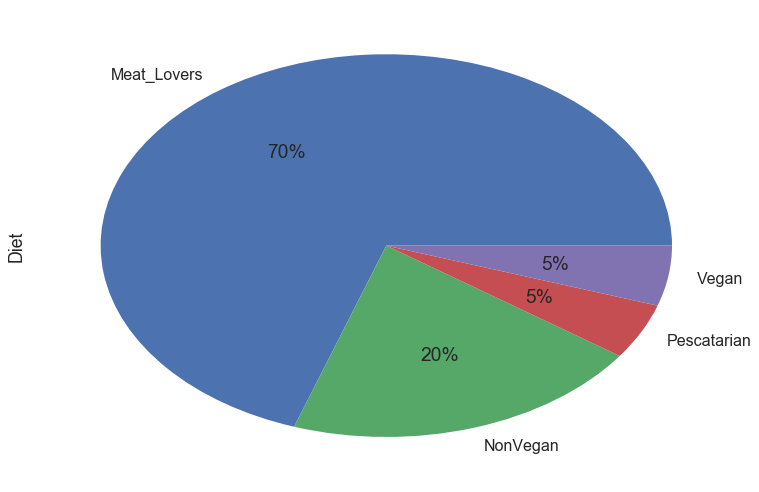

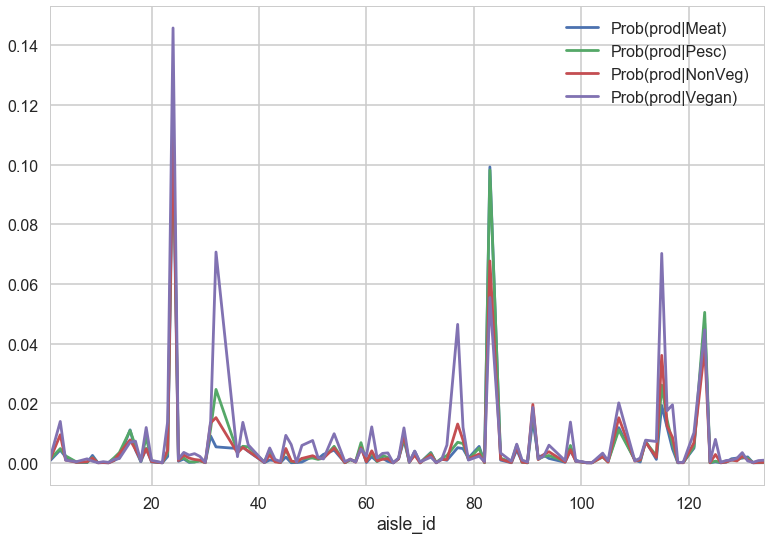

In [124]:
## Using the 10,000 customers in sample 1
Diet_Class(sample1)

In [128]:
## Using another set of random sample from Prior Table

sam.user_id.unique().size

162633

In [135]:
Ex=A.user_id.unique()

In [136]:
new=sam.loc[~sam.user_id.isin(Ex)]

In [137]:
sample2=new.sample(n=10000, replace=False, random_state=0, axis=0)

C:\Users\pamel\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:49: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


(<matplotlib.axes._subplots.AxesSubplot at 0x1bee643af28>,
           Prob(prod|Meat)  Prob(prod|Pesc)  Prob(prod|NonVeg)  \
 aisle_id                                                        
 1                0.000424         0.000681           0.000251   
 3                0.006110         0.008531           0.011701   
 4                0.000788         0.000743           0.000772   
 6                0.000177         0.000372           0.000308   
 8                0.000081         0.000093           0.000288   
 9                0.003072         0.002044           0.001545   
 10               0.000006         0.000403           0.000016   
 11               0.000132         0.000139           0.000205   
 12               0.000045         0.000015           0.000008   
 13               0.000611         0.000728           0.000698   
 14               0.001844         0.002895           0.003496   
 16               0.011442         0.009537           0.007568   
 17              

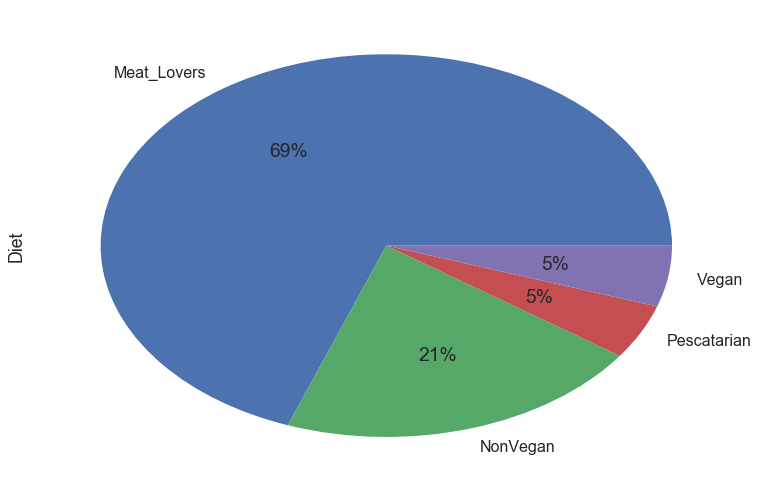

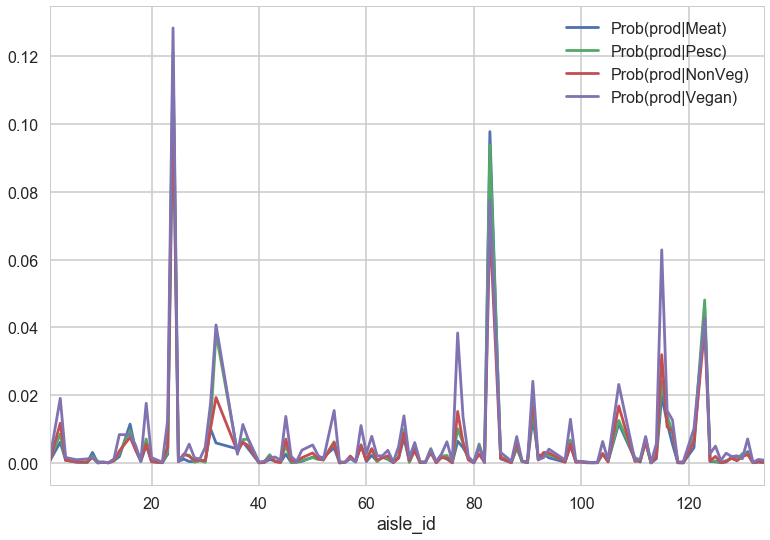

In [138]:
Diet_Class(sample2)

In [140]:
Ex2=sample2.user_id.unique()

10000

In [142]:
new2=new.loc[~new.user_id.isin(Ex2)]
sample3=new2.sample(n=10000, replace=False, random_state=0, axis=0)

C:\Users\pamel\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:49: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


(<matplotlib.axes._subplots.AxesSubplot at 0x1bee4426550>,
           Prob(prod|Meat)  Prob(prod|Pesc)  Prob(prod|NonVeg)  \
 aisle_id                                                        
 1                0.000317         0.000385           0.000229   
 3                0.003879         0.005160           0.008987   
 4                0.001119         0.000972           0.000508   
 6                0.000130         0.000235           0.000140   
 8                0.000019         0.000369           0.000136   
 9                0.003529         0.002982           0.002301   
 10               0.000026         0.000235           0.000021   
 11               0.000008         0.000034           0.000025   
 12               0.000088         0.000168           0.000059   
 13               0.000444         0.000955           0.000131   
 14               0.001632         0.002429           0.002996   
 16               0.010987         0.008678           0.008076   
 17              

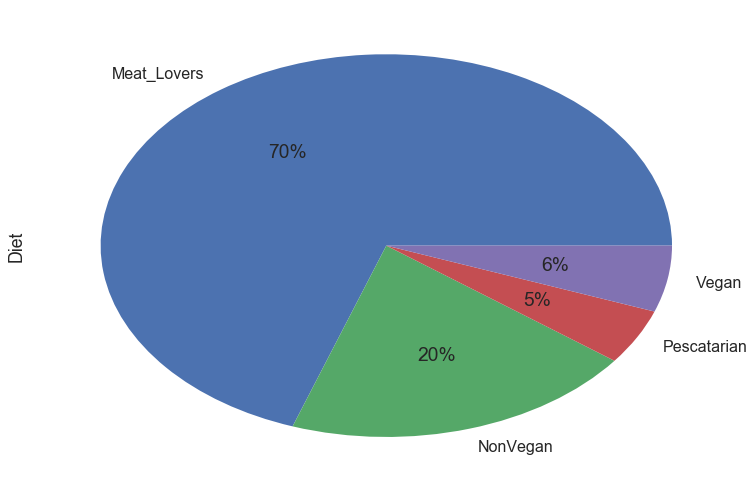

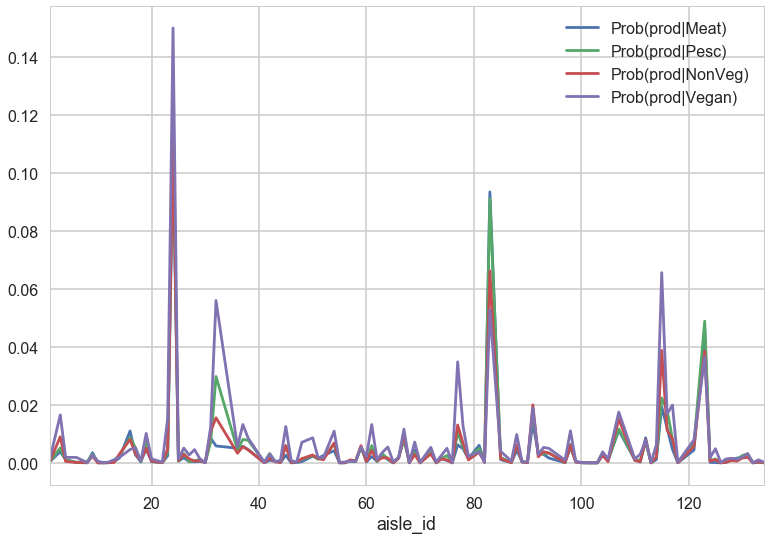

In [143]:
Diet_Class(sample3)